In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn.functional as F

# ========== 1. Device and Data Path ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = 'Covid19-dataset'

In [2]:
# ========== 2. Transforms ==========
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [3]:
# ========== 3. Dataset and Dataloaders ==========
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")
print("Classes:", class_names)

Train size: 251, Test size: 66
Classes: ['Covid', 'Normal', 'Viral Pneumonia']


In [4]:
# ========== 4. Model Setup: ResNet50 Fine-tuned ==========
model = models.resnet50(pretrained=True)

# Modify first conv layer to accept grayscale input
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last block and fc for fine-tuning
for param in model.layer4.parameters():
    param.requires_grad = True

# Update final classification layer
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 3)  # 3 classes
)

model = model.to(device)

/Users/mayuri/PycharmProjects/Lab0/pythonProject/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mayuri/PycharmProjects/Lab0/pythonProject/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# ========== 5. Loss, Optimizer, Scheduler ==========
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)


In [7]:
# ========== 6. Training Loop ==========
num_epochs = 20
best_acc = 0.0
train_losses, train_accuracies, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}")

Epoch [1/20] - Loss: 0.8397, Train Acc: 0.6096, Val Acc: 0.4394
Epoch [2/20] - Loss: 0.3192, Train Acc: 0.8845, Val Acc: 0.5152
Epoch [3/20] - Loss: 0.2828, Train Acc: 0.9044, Val Acc: 0.6061
Epoch [4/20] - Loss: 0.4165, Train Acc: 0.8884, Val Acc: 0.5909
Epoch [5/20] - Loss: 0.3159, Train Acc: 0.8884, Val Acc: 0.6970
Epoch [6/20] - Loss: 0.2634, Train Acc: 0.9044, Val Acc: 0.8939
Epoch [7/20] - Loss: 0.2658, Train Acc: 0.9084, Val Acc: 0.9848
Epoch [8/20] - Loss: 0.1504, Train Acc: 0.9363, Val Acc: 0.9394
Epoch [9/20] - Loss: 0.1576, Train Acc: 0.9482, Val Acc: 0.9697
Epoch [10/20] - Loss: 0.0963, Train Acc: 0.9641, Val Acc: 0.9697
Epoch [11/20] - Loss: 0.0939, Train Acc: 0.9721, Val Acc: 0.9848
Epoch [12/20] - Loss: 0.0983, Train Acc: 0.9761, Val Acc: 1.0000
Epoch [13/20] - Loss: 0.1101, Train Acc: 0.9602, Val Acc: 1.0000
Epoch [14/20] - Loss: 0.1231, Train Acc: 0.9602, Val Acc: 1.0000
Epoch [15/20] - Loss: 0.0747, Train Acc: 0.9721, Val Acc: 1.0000
Epoch [16/20] - Loss: 0.1094, Trai

In [8]:
# ========== 7. Load Best Model ==========
model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [9]:
# ========== 8. Final Evaluation ==========
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\nTest Accuracy: {test_acc:.4f}")


Test Accuracy: 1.0000


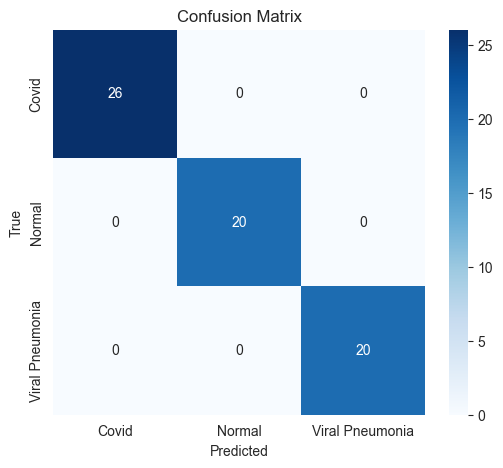

In [10]:
# ========== 9. Confusion Matrix ==========
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



Classification Report:
                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        26
         Normal       1.00      1.00      1.00        20
Viral Pneumonia       1.00      1.00      1.00        20

       accuracy                           1.00        66
      macro avg       1.00      1.00      1.00        66
   weighted avg       1.00      1.00      1.00        66



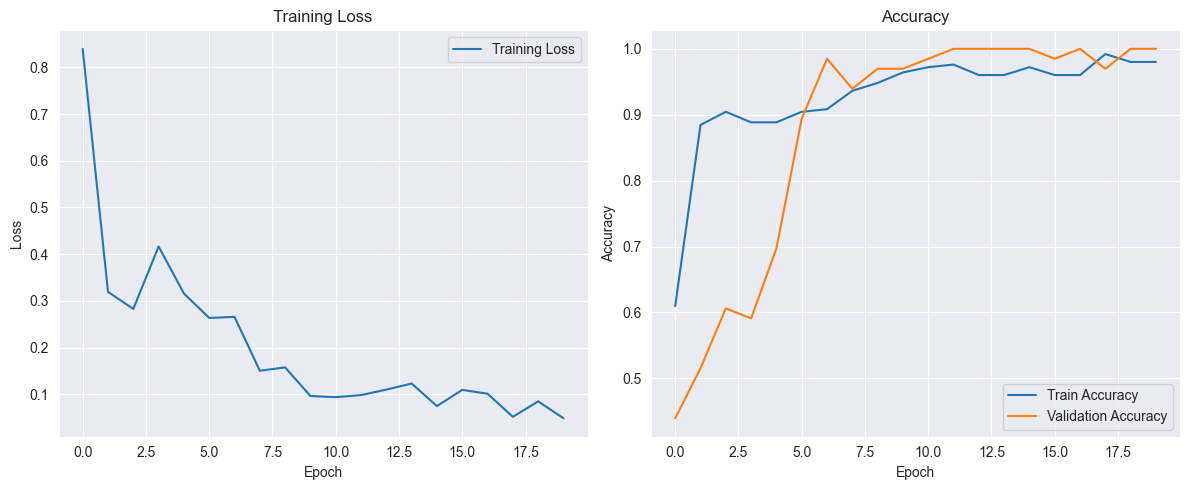

In [11]:
# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ========== 10. Plot Accuracy & Loss ==========
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()